# MNIST за допомогою PCA

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm
import time

## Налаштування та конфігурація

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f" пристрій: {device}")

BATCH_SIZE = 128
EPOCHS = 5
LEARNING_RATE = 0.001
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)


 пристрій: cpu


## Завантаження MNIST

In [6]:
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

X_train_np = train_data.data.numpy().reshape(len(train_data), -1).astype(np.float32) / 255.0
y_train_np = train_data.targets.numpy()

X_test_np = test_data.data.numpy().reshape(len(test_data), -1).astype(np.float32) / 255.0
y_test_np = test_data.targets.numpy()

print(f"Розмір тренувальних даних : {X_train_np.shape}")
print(f"Розмір тестових даних : {X_test_np.shape}")

Розмір тренувальних даних : (60000, 784)
Розмір тестових даних : (10000, 784)


##  PCA та важливість пікселів

In [7]:

n_pixels = X_train_np.shape[1] # 784

# Навчання PCA
pca = PCA(n_components=n_pixels, random_state=RANDOM_SEED)
pca.fit(X_train_np)

# Важливість пікселів
# (784, 784)
pixel_importance = np.sum(pca.components_**2, axis=0)

sorted_pixel_indices = np.argsort(pixel_importance)[::-1]

## Функція маскування

In [8]:
def create_mask(num_pixels_to_keep, sorted_indices, original_dim=784):
    """Збереження k найкращих пікселів."""
    mask = np.zeros(original_dim, dtype=bool)
    kept_indices = sorted_indices[:num_pixels_to_keep]
    mask[kept_indices] = True
    return mask, kept_indices

def apply_mask_np(data_np, mask):
    return data_np[:, mask]

## Проста нейронна мережа

In [9]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, num_classes=10):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x


## Функції тренування та оцінки

In [10]:
transform_normalize = transforms.Compose([
    transforms.Normalize((0.1307,), (0.3081,))
])

def prepare_dataloaders(X_train, y_train, X_test, y_test, batch_size, mask=None):

    # Застосовуємо маску
    if mask is not None:
        X_train_masked = apply_mask_np(X_train, mask)
        X_test_masked = apply_mask_np(X_test, mask)
    else:
        X_train_masked = X_train
        X_test_masked = X_test

    X_train_tensor = torch.tensor(X_train_masked, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test_masked, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    train_mean = X_train_tensor.mean(dim=0, keepdim=True)
    train_std = X_train_tensor.std(dim=0, keepdim=True)
    train_std = torch.where(train_std == 0, torch.tensor(1.0), train_std)

    X_train_normalized = (X_train_tensor - train_mean) / train_std
    X_test_normalized = (X_test_tensor - train_mean) / train_std

    # Датасети
    train_dataset = TensorDataset(X_train_normalized, y_train_tensor)
    test_dataset = TensorDataset(X_test_normalized, y_test_tensor)

    # Завантажувачі даних
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

def train_model(model, train_loader, criterion, optimizer, epochs, device):
    """Тренує модель"""
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

    print(f"Тренування завершено після {epochs} епох.")


def evaluate_model(model, test_loader, device):
    """Оцінює модель."""
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy


## Тренування та оцінка

In [11]:
input_size_full = n_pixels # 784
train_loader_full, test_loader_full = prepare_dataloaders(
    X_train_np, y_train_np, X_test_np, y_test_np, BATCH_SIZE, mask=None
)

model_full = SimpleNN(input_size=input_size_full).to(device)
criterion_full = nn.CrossEntropyLoss()
optimizer_full = optim.Adam(model_full.parameters(), lr=LEARNING_RATE)

start_time = time.time()
train_model(model_full, train_loader_full, criterion_full, optimizer_full, EPOCHS, device)
training_time_full = time.time() - start_time

accuracy_full = evaluate_model(model_full, test_loader_full, device)
print(f"Час : {training_time_full:.2f} секунд")
print(f"Точність : {accuracy_full:.2f}%")

Тренування завершено після 5 епох.
Час : 12.50 секунд
Точність : 97.45%


## Експеримент з даними з маскою

Тестування розмірів маски:   0%|          | 0/12 [00:00<?, ?it/s]


Тренування з Топ 50 пікселями...
Тренування завершено після 5 епох.
Час тренування (50 пікселів): 8.09 секунд
Точність з 50 пікселями: 66.85%

Тренування з Топ 75 пікселями...
Тренування завершено після 5 епох.
Час тренування (75 пікселів): 7.35 секунд
Точність з 75 пікселями: 84.97%

Тренування з Топ 100 пікселями...
Тренування завершено після 5 епох.
Час тренування (100 пікселів): 8.58 секунд
Точність з 100 пікселями: 88.34%

Тренування з Топ 150 пікселями...
Тренування завершено після 5 епох.
Час тренування (150 пікселів): 9.46 секунд
Точність з 150 пікселями: 91.30%

Тренування з Топ 200 пікселями...
Тренування завершено після 5 епох.
Час тренування (200 пікселів): 13.72 секунд
Точність з 200 пікселями: 94.21%


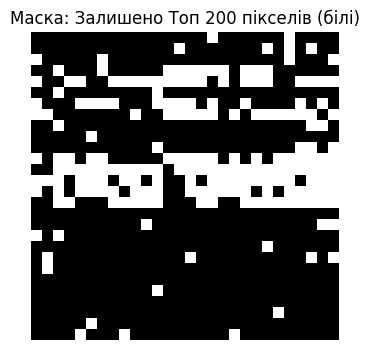


Тренування з Топ 250 пікселями...
Тренування завершено після 5 епох.
Час тренування (250 пікселів): 11.75 секунд
Точність з 250 пікселями: 94.72%

Тренування з Топ 300 пікселями...
Тренування завершено після 5 епох.
Час тренування (300 пікселів): 12.38 секунд
Точність з 300 пікселями: 95.76%

Тренування з Топ 400 пікселями...
Тренування завершено після 5 епох.
Час тренування (400 пікселів): 13.46 секунд
Точність з 400 пікселями: 96.23%

Тренування з Топ 500 пікселями...
Тренування завершено після 5 епох.
Час тренування (500 пікселів): 14.74 секунд
Точність з 500 пікселями: 96.96%

Тренування з Топ 600 пікселями...
Тренування завершено після 5 епох.
Час тренування (600 пікселів): 17.35 секунд
Точність з 600 пікселями: 97.39%

Тренування з Топ 700 пікселями...
Тренування завершено після 5 епох.
Час тренування (700 пікселів): 18.49 секунд
Точність з 700 пікселями: 97.54%

Тренування з Топ 784 пікселями...
Тренування завершено після 5 епох.
Час тренування (784 пікселів): 19.54 секунд
Точн

In [12]:
pixels_to_keep_list = [50, 75, 100, 150, 200, 250, 300, 400, 500, 600, 700, 784] # 784 для порівняння
results = {}

for k in tqdm(pixels_to_keep_list, desc="Тестування розмірів маски"):
    if k > n_pixels: k = n_pixels
    print(f"\nТренування з Топ {k} пікселями...")

    mask, _ = create_mask(k, sorted_pixel_indices, n_pixels)
    input_size_masked = k

    train_loader_masked, test_loader_masked = prepare_dataloaders(
        X_train_np, y_train_np, X_test_np, y_test_np, BATCH_SIZE, mask=mask
    )

    model_masked = SimpleNN(input_size=input_size_masked).to(device)
    criterion_masked = nn.CrossEntropyLoss()
    optimizer_masked = optim.Adam(model_masked.parameters(), lr=LEARNING_RATE)

    start_time = time.time()
    train_model(model_masked, train_loader_masked, criterion_masked, optimizer_masked, EPOCHS, device)
    training_time_masked = time.time() - start_time

    # Оцінка
    accuracy_masked = evaluate_model(model_masked, test_loader_masked, device)
    print(f"Час тренування ({k} пікселів): {training_time_masked:.2f} секунд")
    print(f"Точність з {k} пікселями: {accuracy_masked:.2f}%")
    results[k] = accuracy_masked

    if k == 200:
        mask_img = mask.reshape(28, 28)
        plt.figure(figsize=(4, 4))
        plt.imshow(mask_img, cmap='gray', interpolation='none')
        plt.title(f'Маска: Залишено Топ {k} пікселів (білі)')
        plt.axis('off')
        plt.show()


## Візуалізація

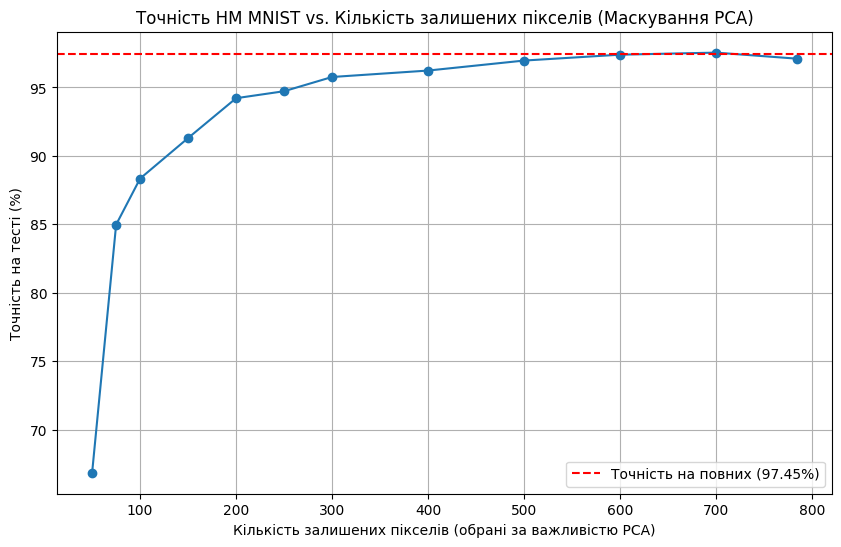

In [15]:
sorted_pixels = sorted(results.keys())
sorted_accuracies = [results[k] for k in sorted_pixels]

plt.figure(figsize=(10, 6))
plt.plot(sorted_pixels, sorted_accuracies, marker='o')
plt.axhline(y=accuracy_full, color='r', linestyle='--', label=f'Точність на повних ({accuracy_full:.2f}%)')
plt.xlabel("Кількість залишених пікселів (обрані за важливістю PCA)")
plt.ylabel("Точність на тесті (%)")
plt.title("Точність НМ MNIST vs. Кількість залишених пікселів (Маскування PCA)")
plt.grid(True)
plt.legend()
plt.show()

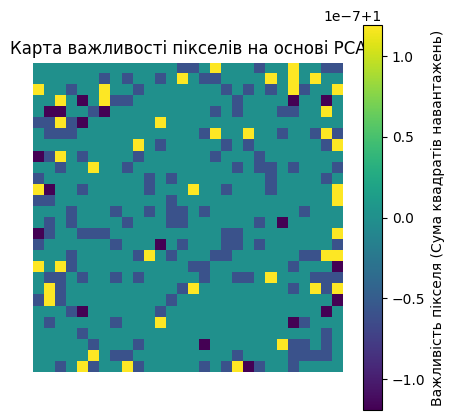

In [16]:
# Важливість пікселів
plt.figure(figsize=(5, 5))
plt.imshow(pixel_importance.reshape(28, 28), cmap='viridis')
plt.colorbar(label='Важливість пікселя (Сума квадратів навантажень)')
plt.title('Карта важливості пікселів на основі PCA')
plt.axis('off')
plt.show()

## Висновок

In [17]:
print(f"Базова точність з {n_pixels} пікселями: {accuracy_full:.2f}%")

best_k = max(results, key=results.get)
print(f"Найвища точність ({results[best_k]:.2f}%) з {best_k} пікселями (з маскою).")

threshold = accuracy_full * 0.99
optimal_k = n_pixels
for k in sorted_pixels:
    if k in results and results[k] >= threshold:
        optimal_k = k
        break

print(f"Найменша кількість пікселів для досягнення точності >= {threshold:.2f}% (99% від базової): {optimal_k} пікселів (Точність: {results.get(optimal_k, 'N/A'):.2f}%)")
if optimal_k <= n_pixels:
    print(f"Це означає, що потенційно ~{n_pixels - optimal_k} пікселів можна видалити з мінімальною втратою точності для цієї конкретної моделі та завдання.")
else:
    print("Не вдалося знайти кількість пікселів, що відповідає порогу 99% базової точності зі списку протестованих.")

Базова точність з 784 пікселями: 97.45%
Найвища точність (97.54%) з 700 пікселями (з маскою).
Найменша кількість пікселів для досягнення точності >= 96.48% (99% від базової): 500 пікселів (Точність: 96.96%)
Це означає, що потенційно ~284 пікселів можна видалити з мінімальною втратою точності для цієї конкретної моделі та завдання.
